In [1]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

In [2]:
np.random.seed(seed=0)

data = pd.read_csv("../datas/Reviews.csv", nrows=100000)
print('전체 리뷰 개수 :', (len(data)))

전체 리뷰 개수 : 100000


In [3]:
data.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
data = data[['Text', 'Summary']]
data.head()

,Text,Summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised
2,This is a confection that has been around a fe...,"""Delight"" says it all"
3,If you are looking for the secret ingredient i...,Cough Medicine
4,Great taffy at a great price. There was a wid...,Great taffy


In [5]:
data.sample(10)

,Text,Summary
3582,"I rarely eat anything but whole wheat pasta, b...",reminds me of Italy
60498,I absolutely love 5-hour ENERGY! I use it afte...,5-hour ENERGY Highly Recommend!
53227,"this chocolate is a true treat to eat, perfect...",supreme chocolate
21333,Greenies are very muched loved as a tatsy Trea...,Excellent Teeth Cleaner
3885,I love these noodles. They are really great f...,Great and good price!
51521,These are great! As a lover of all chips I'm s...,"Delicious, just like Salt and Vinegar Chips!"
84261,Like other customers I divide these into handf...,"Great snack, great value"
10685,I recommend this instead for the same price: <...,"It's ok, but certainly not worth the cost"
59948,"The noodles were all very broken, but the tast...",Knorr's beef noodles
41032,"Despite claiming they use the ""finest ingredie...",HORRIBLE INGREDIENTS


In [6]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())  # 데이터 확인 단계
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 88426
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 72348


In [7]:
data.drop_duplicates(subset=['Text'], inplace=True)
print("전체 샘플 수 :", len(data))

전체 샘플 수 : 88426


In [8]:
print(data.isnull().sum())

Text       0
Summary    1
dtype: int64


In [9]:
data.dropna(axis=0, inplace=True)
print('전체 샘플 수 :', (len(data)))

전체 샘플 수 : 88425


In [10]:
contractions = {"ain't": "is not", "aren't": "are not", "can't": "cannot", "'cause": "because",
                "could've": "could have", "couldn't": "could not", "didn't": "did not", "doesn't": "does not",
                "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
                "he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is", "I'd": "I would", "I'd've": "I would have", "I'll": "I will",
                "I'll've": "I will have", "I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have",
                "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not",
                "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have",
                "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
                "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would",
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                "so've": "so have", "so's": "so as", "this's": "this is", "that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                "there'd've": "there would have", "there's": "there is", "here's": "here is", "they'd": "they would",
                "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have",
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not",
                "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
                "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have",
                "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have",
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not",
                "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                "you're": "you are", "you've": "you have"}
# 전처리를 위한 vocab

In [11]:
stop_words = set(stopwords.words('english'))  # nltk의 영어 불용어 제거 사용
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{"you'd", 'is', 'once', 'our', 'few', 've', "doesn't", 'theirs', 'about', 'ma', 'we', "you've", 'she', 'than', 'o', 'in', 'where', 'hers', 'whom', 'themselves', 'yours', 'hadn', 'couldn', "you're", 'ourselves', 'the', 'but', "it's", 'only', 'your', 'how', 'ours', 'as', 'down', 'isn', 'having', 'does', 'what', 'had', 'such', 'him', 's', 'its', 'her', 'his', "wouldn't", 'ain', 'now', "didn't", 'doesn', 'same', "don't", 'and', "mustn't", 'after', 'some', "won't", "you'll", "weren't", 'here', 'y', 'you', 'there', 'no', 'hasn', "isn't", 'against', 'i', 'was', 'both', 'been', 'do', 'why', 'itself', "couldn't", 'being', 'between', 'at', 'those', 'just', 'any', 'by', 'each', 'my', 'not', 'who', 'nor', 'can', 'into', "needn't", 'haven', 'before', 'if', "aren't", 'have', 'didn', 'be', 'during', "shouldn't", "wasn't", 'this', 'needn', 'under', 'did', 'myself', 'further', 'so', "should've", 'which', 'very', 're', 'above', 'to', 'these', 'other', 'should', 'an', 'am', 'will', 'don', 'a

In [12]:
def preprocess_sentence(sentence, remove_stopwords=True):  # 전처리 프로세스 ( 이 부분에서 사용하는 방법 익히기 )
    sentence = sentence.lower()
    sentence = BeautifulSoup(sentence, "lxml").text  # html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)  # 괄호도 닫혀있는 문자열 제거

    sentence = re.sub('"', '', sentence)
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")])  # 약어 정규화
    sentence = re.sub(r"'s/b", "", sentence)  # 소유격 제거
    sentence = re.sub("[^a-zA-Z]", " ", sentence)  #영어 외 문자 공백 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence)  # m이 3개 이상일 시 2개로 변경 ex ) umm 같은 표현 때문

    if remove_stopwords:
        # 불용어 제거
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    else:
        # 불용어 미제거
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)

    return tokens

In [13]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'
print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, 0))

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


In [14]:
from tqdm import tqdm

clean_text = []
for s in tqdm(data['Text']):
    clean_text.append(preprocess_sentence(s))  # 원래 data 전체 전처리
clean_text[:5]

100%|██████████| 88425/88425 [00:26<00:00, 3309.69it/s]


['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
 'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'great taffy great price wide assortment yummy taffy delivery quick taffy lover deal']

In [15]:
clean_summary = []
for s in tqdm(data['Summary']):
    clean_summary.append(preprocess_sentence(s))  # 원래 data 전체 전처리
clean_summary[:5]

  9%|▉         | 8362/88425 [00:02<00:23, 3444.32it/s]c:\users\yoonhyeonjun\appdata\local\programs\python\python36\lib\site-packages\bs4\__init__.py:343: MarkupResemblesLocatorWarning: "..." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning
 71%|███████▏  | 63149/88425 [00:18<00:07, 3476.94it/s]c:\users\yoonhyeonjun\appdata\local\programs\python\python36\lib\site-packages\bs4\__init__.py:438: MarkupResemblesLocatorWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  MarkupResemblesLocatorWarning
100%|██████████| 88425/88425 [00:25<00:00, 3462.55it/s]


['good quality dog food',
 'advertised',
 'delight says',
 'cough medicine',
 'great taffy']

In [16]:
data['Text'] = clean_text  # 원래 데이터에 전처리한 데이터 삽입
data['Summary'] = clean_summary

In [17]:
data.replace('', np.nan, inplace=True)  # 빈 데이터를 nan을 바꾸어줌
print(data.isnull().sum())

Text         0
Summary    291
dtype: int64


In [18]:
data.dropna(axis=0, inplace=True)  # na로 바꾸어준 것들을 모두 지운다
print('전체 샘플수', (len(data)))

전체 샘플수 88134


In [19]:
text_len = [len(s.split()) for s in data['Text']]  # 각 텍스트의 길이만 들어가있는 리스트 작성
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))  # 가장 작고 큰 길이를 만들어 텍스트 분포도를 만들 떄 사용
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 2
텍스트의 최대 길이 : 1235
텍스트의 평균 길이 : 38.796627862119045
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 2.871922300133887


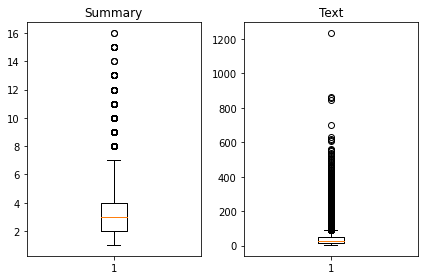

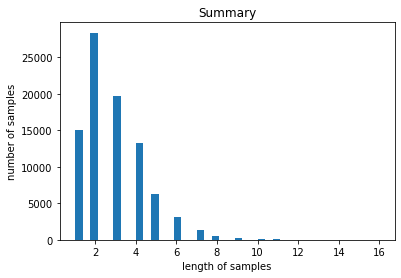

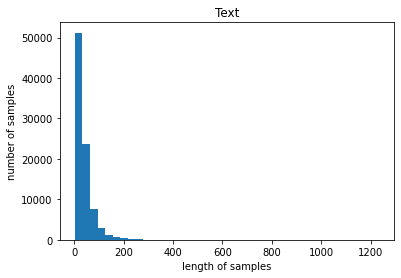

In [20]:
plt.subplot(1, 2, 1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1, 2, 2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [21]:
text_max_len = 100  # 분포도를 보고 내가 정한 텍스트의 최대 길이
summary_max_len = 8  # 분포도를 보고 내가 정한 요약본의 최대 길이

In [22]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if len(s.split()) <= max_len:
            cnt += 1
    print("전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s" % (max_len, (cnt / len(nested_list))))

In [23]:
below_threshold_len(text_max_len, data['Text'])

전체 샘플 중 길이가 100 이하인 샘플의 비율 : 0.9448907345632787


In [24]:
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 8 이하인 샘플의 비율 : 0.9944289377538748


In [25]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플 수:', len(data))

전체 샘플 수: 82925


In [26]:
data.head()

,Text,Summary
0,bought several vitality canned dog food produc...,good quality dog food
1,product arrived labeled jumbo salted peanuts p...,advertised
2,confection around centuries light pillowy citr...,delight says
3,looking secret ingredient robitussin believe f...,cough medicine
4,great taffy great price wide assortment yummy ...,great taffy


In [27]:
data['decoder_input'] = data['Summary'].apply(lambda x: 'sostoken ' + x)
data['decoder_target'] = data['Summary'].apply(lambda x: x + ' eostoken')
data.head()

,Text,Summary,decoder_input,decoder_target
0,bought several vitality canned dog food produc...,good quality dog food,sostoken good quality dog food,good quality dog food eostoken
1,product arrived labeled jumbo salted peanuts p...,advertised,sostoken advertised,advertised eostoken
2,confection around centuries light pillowy citr...,delight says,sostoken delight says,delight says eostoken
3,looking secret ingredient robitussin believe f...,cough medicine,sostoken cough medicine,cough medicine eostoken
4,great taffy great price wide assortment yummy ...,great taffy,sostoken great taffy,great taffy eostoken


In [28]:
encoder_input = np.array(data['Text'])  # inpuㅅ
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

In [29]:
encoder_input

array(['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
       'product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo',
       'confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch',
       ...,
       'late father law used rating system meals particularly tasty would say tastes like exactly felt first time tried spicy picante ramyun ordered whim featured gold box deal would enjoyed ramen noodles past even though would never tried brand figured less dollar package could afford take chance boy glad spicy flavorful delicious immediately wanted second helping talk use

In [30]:
indices = np.arange(encoder_input.shape[0])  # encoder의 길이만큼 섞기 위해서 shape를 가져옴
np.random.shuffle(indices)  # shuffle
print(indices)

[18207 57973  6666 ... 78276 26023  1298]


In [31]:
encoder_input = encoder_input[indices]  # 샘플 섞기
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [32]:
n_of_val = int(len(encoder_input) * 0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 16585


In [33]:
# train test 비율 8:2로 나눔

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [34]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 66340
훈련 레이블의 개수 : 66340
테스트 데이터의 개수 : 16585
테스트 레이블의 개수 : 16585


In [35]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 생성 후 정수 인코딩 수행

In [36]:
src_tokenizer.word_index

{'like': 1,
 'good': 2,
 'great': 3,
 'taste': 4,
 'one': 5,
 'would': 6,
 'product': 7,
 'flavor': 8,
 'coffee': 9,
 'love': 10,
 'tea': 11,
 'get': 12,
 'food': 13,
 'really': 14,
 'amazon': 15,
 'much': 16,
 'little': 17,
 'price': 18,
 'time': 19,
 'buy': 20,
 'best': 21,
 'also': 22,
 'use': 23,
 'tried': 24,
 'find': 25,
 'better': 26,
 'make': 27,
 'chocolate': 28,
 'dog': 29,
 'well': 30,
 'try': 31,
 'even': 32,
 'eat': 33,
 'drink': 34,
 'first': 35,
 'could': 36,
 'bag': 37,
 'sugar': 38,
 'sweet': 39,
 'cup': 40,
 'found': 41,
 'bought': 42,
 'used': 43,
 'made': 44,
 'water': 45,
 'box': 46,
 'tastes': 47,
 'cannot': 48,
 'order': 49,
 'way': 50,
 'free': 51,
 'recommend': 52,
 'store': 53,
 'delicious': 54,
 'think': 55,
 'go': 56,
 'nice': 57,
 'two': 58,
 'bit': 59,
 'since': 60,
 'favorite': 61,
 'day': 62,
 'give': 63,
 'mix': 64,
 'loves': 65,
 'still': 66,
 'got': 67,
 'dogs': 68,
 'many': 69,
 'know': 70,
 'flavors': 71,
 'hot': 72,
 'never': 73,
 'want': 74,
 'som

In [37]:
threshold = 7  # 빈도수 임의로 7개 설정
total_cnt = len(src_tokenizer.word_index)  # 단어의 갯수
rare_cnt = 0  # 설정 빈도수 보다 적은 빈도수를 가진 단어 수 체크
total_freq = 0  # 훈련 데이터의 전체 답어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 설정 빈도수보다 작은 단어들의 총합

# 단어의 key, value를 쌍으로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    if value < threshold:
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합 크기', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합 크기 42096
등장 빈도가 6번 이하인 희귀 단어의 수: 30920
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11176
단어 집합에서 희귀 단어의 비율: 73.4511592550361
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.5965318794699774


In [38]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab)  # 단어 집합을 8000개로 제한한 토크나이저
src_tokenizer.fit_on_texts(encoder_input_train)  # 텍스트 빈도수 인코딩

encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)  # 시퀀스를 정수 시퀀스로 변경
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [39]:
encoder_input_train[:3]

[[4349, 205, 297, 254, 809, 66, 5143, 996, 1134, 6, 144, 52, 254, 1638],
 [4350,
  1462,
  1609,
  628,
  6590,
  335,
  1080,
  2254,
  916,
  1709,
  545,
  287,
  62,
  374,
  740,
  1462,
  260,
  2425,
  472,
  6590,
  41,
  763,
  2961,
  750,
  617,
  4,
  116,
  133,
  16,
  25,
  170,
  1462,
  716,
  380,
  55,
  6,
  293,
  17,
  516,
  3908,
  374,
  287,
  19,
  31,
  1035,
  724,
  6,
  348,
  1092,
  388],
 [500,
  23,
  2898,
  554,
  490,
  274,
  30,
  645,
  254,
  554,
  9,
  293,
  130,
  6790,
  924,
  147,
  639,
  23,
  737,
  19,
  221,
  832,
  130,
  254,
  554,
  9]]

In [40]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_target_train)

In [41]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if (value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s' % (threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s' % (total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 12367
등장 빈도가 5번 이하인 희귀 단어의 수: 9473
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 2894
단어 집합에서 희귀 단어의 비율: 76.59901350367915
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.36763749396475


In [42]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)  # 단어 빈도를 index를 가진 시퀀스로 만들어서 학습한다고 해서 fit_on_text?

In [43]:
# fit_on_texts 안에 corpus를 입력하면 tokenizer에 단어 빈도수를 가지며 학습

In [44]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)  # text를 sequences로 변경
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [45]:
print(decoder_input_train[:5])

[[1, 415], [1, 714, 11], [1, 230, 727], [1, 4, 13], [1, 72]]


In [46]:
print(decoder_target_train[:5])

[[415, 2], [714, 11, 2], [230, 727, 2], [4, 13, 2], [72, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]  # 삭제할 index를 추출
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [48]:
print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 2052
삭제할 테스트 데이터의 개수 : 543


In [49]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)  # 삭제하기 위해서 추출한 값 삭제
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 64288
훈련 레이블의 개수 : 64288
테스트 데이터의 개수 : 16042
테스트 레이블의 개수 : 16042


c:\users\yoonhyeonjun\appdata\local\programs\python\python36\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [50]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len,
                                    padding='post')  # 각 encoder, decoder 별로 padding 작업 진행
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [51]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate  # 요약모델 훈련을 위한 import
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))  # 텍스트 최대 길이를 가진 shape로 input 층 생성

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)  # embedding shape 맞춰주기

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [53]:
# 디코더
decoder_inputs = Input(shape=(None,))  # layer를 건너 decoder에 들어오는 input 계층 설정

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)  # 디코더에서
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [54]:
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')  # softmax로 확률 화 해줌
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)  # softmax alyer 생성

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [55]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py",
                           filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x2788f4ed390>)

In [56]:
from attention import AttentionLayer  # attention model import

attn_layer = AttentionLayer(name='attention_layer')  # attention layer 추가


# 어텐션의 결과와 디코더의 hidden state들을 연결

In [60]:
type(attn_layer)

attention.AttentionLayer

In [57]:
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])  # attention layet에 encoder, decoder 삽입

In [58]:
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

In [59]:

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 128)     1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100, 256), ( 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [61]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [63]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)  # 특정점 이상의 변동이 없을시 조기 중단
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
                    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size=256, callbacks=[es], epochs=50
                    )

Epoch 1/50
252/252 [==============================] - 6251s 25s/step - loss: 2.5999 - val_loss: 2.0333

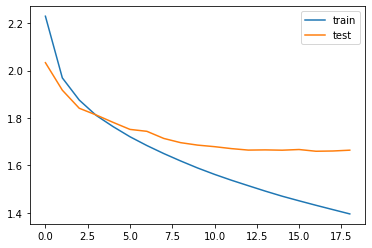

In [64]:
# model을 돌리며 손실된 것을 그래프로 출력
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [65]:
src_index_to_word = src_tokenizer.index_word  # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index  # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word  # 요약 단어 집합에서 정수 -> 단어를 얻음

In [66]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [67]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2,
                                                    initial_state=[decoder_state_input_h, decoder_state_input_c])

In [68]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [69]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:  # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token != 'eostoken'):
            decoded_sentence += ' ' + sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken' or len(decoded_sentence.split()) >= (summary_max_len - 1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [70]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    sentence = ''
    for i in input_seq:
        if (i != 0):
            sentence = sentence + src_index_to_word[i] + ' '
    return sentence


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    sentence = ''
    for i in input_seq:
        if ((i != 0 and i != tar_word_to_index['sostoken']) and i != tar_word_to_index['eostoken']):
            sentence = sentence + tar_index_to_word[i] + ' '
    return sentence

In [71]:
for i in range(500, 1000):
    print("원문 : ", seq2text(encoder_input_test[i]))
    print("실제 요약문 :", seq2summary(decoder_input_test[i]))
    print("예측 요약문 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  first time buying local grocery store sale hooked every since wonderful drink especially cold refreshing drink summer one hot days thoroughly enjoy one favorite flavors would make peach flavor 
실제 요약문 : good last drop 
예측 요약문 :  delicious


원문 :  father law treated colon cancer knows helped goes nasty sessions said makes difference energy level man skeptical person even say much wow make want keep without vendors prompt delivery much appreciated 
실제 요약문 : makes difference 
예측 요약문 :  love


원문 :  little dachshund loves stuff picky right size easily chew nice find amazon since variety always available store 
실제 요약문 : great dog food picky dogs 
예측 요약문 :  great


원문 :  split work get balanced view dark coffee fan sweetened coffee fan us agree bitter coffee flavor sweetened coffee fan really like type puts sugar coffee probably flavor dark coffee fan enjoyed agreed dark flavor full little bitter going come like coffee sweet sweetened coffee drinkers going like much like stronger coffe

In [ ]:
print("원문 : ", seq2text("안녕하세요 저는 윤현준입니다. 안녕하세에에요"))
print("실제 요약문 :", seq2summary(decoder_input_test[i]))
print("예측 요약문 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))

In [73]:
encoder_input_test[600]

array([  58,  443,   10, 1463,  298,   12,   98,  247,   41,  707,  124,
         10,   44, 1108, 1108,  116,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])